# 変分法と変分量子固有値ソルバー法を学習する

この実習では、変分法の基本的な考え方と、その方法に基づいた変分量子アルゴリズムと呼ばれる量子計算の手法を学びます。特に、量子計算と古典計算を組み合わせた「**量子・古典ハイブリッドアルゴリズム**」としての変分量子アルゴリズムに着目します。この手法を用いて、近似的な固有値計算を可能にする**変分量子固有値ソルバー法**と呼ばれる方法へ拡張していきます。

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{| #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 |}$
$\newcommand{\braket}[2]{\langle #1 | #2 \rangle}$
$\newcommand{\expval}[3]{\langle #1 | #2 | #3 \rangle}$

## はじめに
行列で表現されるある物理系に対して、その最も小さい固有値を見つけるという操作は、多くのアプリケーションで必要となる重要な技術です。例えば化学の計算では、分子を特徴づけるエルミート行列の最小固有値はそのシステムの最もエネルギーの低い状態（基底状態）のエネルギーになります。最小固有値を見つけるには「**量子位相推定**」と呼ばれる手法（この{doc}`課題 <spectrum_estimation>`を参照）を使うことができますが、この手法を使って実用的な問題を解こうとすると、そのために必要な量子回路はNISQコンピュータでは実現できないほど長くなることが知られています。そのために、短い量子回路を利用して分子の基底状態エネルギーを推定する手法として、**変分量子固有値ソルバー法**（*Variational Quantum Eigensolver*, VQE）が提案されました {cite}`vqe`。

まず、VQEの元になる関係を形式的に表現してみましょう。何か分からない最小固有値$\lambda_{min}$とその固有状態$\ket{\psi_{min}}$をもったエルミート行列$H$が与えられたとして、VQEはその系のエネルギーの下限である$\lambda_{min}$の近似解$\lambda_{\theta}$を求める手法です。つまり

$$
\lambda_{min} \le \lambda_{\theta} \equiv \expval{ \psi(\theta)}{H}{\psi(\theta) }
$$

を満たす、できるだけ小さい$\lambda_{\theta}$を求めることに対応します。ここで$\ket{\psi(\theta)}$は近似解$\lambda_{\theta}$に対応する状態で、$\theta$はパラメータです。つまり、適当な初期状態$\ket{\psi}$にユニタリー$U(\theta)$で表現されるパラメータ化された回路を適用することで、$\ket{\psi_{min}}$を近似する状態$\ket{\psi(\theta)} \equiv U(\theta)\ket{\psi}$を得ようというアイデアです。最適なパラメータ$\theta$の値は、期待値 $\expval{\psi(\theta)}{H}{\psi(\theta)}$が最小になるように古典計算を繰り返しながら求めていくことになります。

## 量子力学における変分法

### 背景

VQEは量子力学の**変分法**を応用した手法です。変分法をより良く理解するために、基礎的な数学的背景を見てみましょう。

行列$A$の固有ベクトル$\ket{\psi_i}$とその固有値$\lambda_i$は、$A \ket{\psi_i} = \lambda_i \ket{\psi_i}$という関係を持っていますね。行列$H$がエルミート行列$H = H^{\dagger}$の場合、スペクトル定理から$H$の固有値は実数になります（$\lambda_i = \lambda_i^*$）。実際に実験で測定できる量は実数である必要があるため、量子系のハミルトニアンを記述するためにはエルミート行列が適切です。さらに、$H$は以下のように表現することもできます。

$$
H = \sum_{i = 1}^{N} \lambda_i \ket{\psi_i} \bra{ \psi_i }
$$

ここで、各$\lambda_i$は固有ベクトル$\ket{\psi_i}$に対応する固有値です。任意の量子状態$\ket{\psi}$に対して観測量$H$を測定した時の期待値は、以下の式で与えられます。

$$
\langle H \rangle_{\psi} \equiv \expval{ \psi }{ H }{ \psi }
$$

上式の$H$を期待値の式に代入すると

$$
\begin{aligned}
\langle H \rangle_{\psi} = \expval{ \psi }{ H }{ \psi } &= \bra{ \psi } \left(\sum_{i = 1}^{N} \lambda_i \ket{\psi_i} \bra{ \psi_i }\right) \ket{\psi}\\
&= \sum_{i = 1}^{N} \lambda_i \braket{ \psi }{ \psi_i} \braket{ \psi_i }{ \psi} \\
&= \sum_{i = 1}^{N} \lambda_i | \braket{ \psi_i }{ \psi} |^2
\end{aligned}
$$

になります。最後の式は、任意の状態$\ket{\psi}$に対する$H$の期待値は、$\lambda_i$を重みとした固有ベクトル$\ket{\psi_i}$と$\ket{\psi}$の内積（の絶対値二乗）の線形結合として与えられることを示しています。この式から、$| \braket{ \psi_i }{ \psi} |^2 \ge 0$ であるために

$$
\lambda_{min} \le \langle H \rangle_{\psi} = \expval{ \psi }{ H }{ \psi } = \sum_{i = 1}^{N} \lambda_i | \braket{ \psi_i }{ \psi} |^2
$$

が成り立つことは明らかです。上記の式が**変分法**と呼ばれるもの（テキストによっては**変分原理**と呼ぶ）で、波動関数を「うまく取る」ことで、ハミルトニアン$H$の期待値の下限として最小固有値を近似的に求めることができることを表しています。この式から、$\ket{\psi_{min}}$状態の期待値は$\expval{ \psi_{min}}{H}{\psi_{min}} = \expval{ \psi_{min}}{\lambda_{min}}{\psi_{min}} = \lambda_{min}$になることも分かるでしょう。

### 基底状態の近似
系のハミルトニアンがエルミート行列$H$で表現されている場合、系の基底状態のエネルギーは$H$の最小固有値になります。まず$\ket{\psi_{min}}$の初期推定としてある波動関数$\ket{\psi}$（*Ansatz*と呼ばれる）を選び、その状態での期待値$\langle H \rangle_{\psi}$を計算します。変分法の鍵は、この期待値が小さくなるように波動関数を更新しながら計算を繰り返し、ハミルトニアンの基底状態エネルギーに近づけていくところにあります。

(vqa)=
## 変分量子アルゴリズム

まず、VQEの元になっている**変分量子アルゴリズム**（*Variational Quantum Algorithm*, VQA）と呼ばれる手法について見ていきます。

### 変分量子回路
量子コンピューター上で変分法を実装するには、*Ansatz*を更新する仕組みが必要です。量子状態の更新には量子ゲートが使えることを、私たちは知っていますね。VQAも量子ゲートを使いますが、VQAは決まった構造を持つパラメータ化された量子回路（**変分量子回路**と呼ばれる）を使って行います。この回路は**変分フォーム**（*variational form*）と呼ばれる場合もあり、回路をひとまとめにしてユニタリー変換$U(\theta)$と書くことも多いです（$\theta$はパラメータで、複数ある場合はベクトルになります）。

変分フォームを初期状態$\ket{\psi}$（例えば標準状態$\ket{0}$）に適用すると、出力として$\ket{\psi(\theta)} \equiv U(\theta)\ket{\psi}$が生成されます。この状態の元で期待値$\expval{ \psi(\theta)}{H}{\psi(\theta)}$が$\lambda_{min}$に近付くように、$\ket{\psi(\theta)}$に対してパラメータ$\theta$の最適化を行うのがVQEです。パラメータの最適化は古典計算で実行することを想定しており、その意味でVQEは典型的な**量子・古典ハイブリッドアルゴリズム**の一つです。

変分フォームの決め方ですが、解きたい問題のドメインに応じて特定の構造を持つ変分フォームを導入することがあります。そうではなく、幅広い問題への応用ができるようにドメインに依存しない形の変分フォーム（例えば$R_X$や$R_Y$などの回転ゲート）を使うこともあります。後で高エネルギー実験へのVQEの応用を課題として考えますが、そこでは$R_Y$と制御$Z$ゲートを使った変分フォームを実装します。

### 単純な変分フォーム
変分フォームを決める時には、2つの相反する目的に対するバランスを考える必要があります。$n$量子ビットの変分フォームは、パラメータの数を増やせば実自由度$2^{n+1}-2$の任意の状態ベクトル$\ket{\psi}$を生成できるでしょう。しかし、パラメータを最適化することを考えれば、できるだけ少ないパラメータで変分フォームを構築したいですよね。回転角をパラメータとする回転ゲートの数が増えれば、量子コンピュータで動かす場合はそれだけノイズの影響を受けやすくなります。なので、できるだけ少ないパラメータ（やゲート）で求める状態を生成できればベストでしょう。

ここでは、まず$n=1$の場合を考えます。Qiskitの$U$ゲート（上の$U(\theta)$ノーテーションと紛らわしいですが、こちらは単一のゲート）は3つのパラメータ$\theta$、$\phi$、$\lambda$を使って以下の変換を表現します:

$$
U(\theta, \phi, \lambda) = \begin{pmatrix}\cos\frac{\theta}{2} & -e^{i\lambda}\sin\frac{\theta}{2} \\ e^{i\phi}\sin\frac{\theta}{2} & e^{i\lambda + i\phi}\cos\frac{\theta}{2} \end{pmatrix}
$$

変分フォームの初期状態を$\ket{0}$に取るならば、上の行列の第一列のみが状態生成に寄与し、$\theta$と$\phi$の2つのパラメータで任意の単一量子ビット状態を表現できます。そういう意味で、この変分フォームは**ユニバーサル**であると言います。ただ、ユニバーサルに任意の状態を生成できるということは、この変分フォームが生成する状態を使ってあるハミルトニアン$H$の期待値を計算しようとした場合、その固有状態を近似する状態だけでなく、それ以外のさまざまな状態も含むということになります。つまり、VQEで最小固有値を効率的に決められるかどうかは、こういう不要な状態を避けつつ、古典計算でいかに適切にパラメータを最適化できるかにかかっているわけです。

### パラメータの最適化
パラメータ化された変分フォームを選択したら、所望の量子状態を作ることができるように、変分法に従ってパラメータを最適化する必要があります。パラメータの最適化のプロセスには様々な課題があります。例えば量子ハードウェアには様々なタイプのノイズがあるため、その状態でエネルギーを測定しても正しい答えが返ってくるという保証はありません。そのために、パラメータの最適化に使う目的関数の評価が実際のエネルギーの値からずれてしまい、正しくパラメータの更新ができない可能性があります。また、最適化の手法（**オプティマイザー**）によっては、パラメータの数に依って目的関数を評価する回数が増えることがあり、ノイズの影響をさらに受けやすくなります。つまり、アプリケーションの要求を考慮しながら、オプティマイザーの選択にも気を配る必要があります。

最も一般的な最適化手法は、エネルギーの減少が極大になるような方向に各パラメータを更新する**勾配降下法**です。各パラメータごとに勾配を計算するため、最適化すべきパラメータの数に応じて目的関数を評価する回数は増えます。また、この性質から探索空間の中で局所的な最適値を素早く発見することは可能ですが、逆に探索が局所的な最小値に留まってしまうことがあります。勾配降下法は直感的で理解しやすい最適化の手法ですが、少なくとも現在のNISQコンピュータでは精度良く実行することは難しいと考えられています（VQEを実装する時に、勾配計算を使った最適化の方法を紹介します）。

ノイズのある量子コンピュータで目的関数を最適化する適切なオプティマイザーとして、*Simultaneous Perturbation Stochastic Approximation*（**SPSA**）{cite}`bhatnagar_optimization`があります。SPSAは2回の測定だけで目的関数の勾配を近似できるという特徴があります。勾配降下法では各パラメータを独立に変化させるのに対して、SPSAでは全てのパラメータを同時にランダムに変化させます。以上のことから、VQEを利用する場合のオプティマイザーとしてSPSAが推奨されることがあります。

ノイズがない量子コンピュータで目的関数を評価する場合（例えば状態ベクトルシミュレータで実行する場合など）は、Pythonの<a href="https://www.scipy.org/scipylib/index.html" target="_blank">SciPy</a>パッケージで提供されているオプティマイザーなど、様々な選択肢があります。この実習では、Qiskitでサポートされているオプティマイザーの中で、特に*Constrained Optimization by Linear Approximation*（**COBYLA**）と呼ばれるオプティマイザーも使用します。COBYLAは目的関数の評価を1回しか実行しない（つまり評価の回数がパラメータの数に依存しない）ため、ノイズがない状態でかつ評価の回数を少なくしたい場合にはCOBYLAの利用が推奨されているようです。いずれにしろ、どのオプティマイザーがベストかはVQEアルゴリズムの実装形式や実行環境によって変わるため、ある程度経験によって決める必要があると考えられます。

### 変分フォームを使った実例
ではここで、$U$ゲート一つからなる単一量子ビットの変分フォームを利用してパラメータ最適化の例を実行してみましょう。ランダムに量子状態$\ket{\psi_0}$を選び、$\ket{\psi(\theta, \phi)} := U(\theta, \phi, 0)\ket{0}$でそれを近似するという問題を考えます[^actually_exact]。1量子ビットの状態は観測量$X, Y, Z$の期待値$\langle X \rangle, \langle Y \rangle, \langle Z \rangle$の値がわかれば（全体位相を除いて）完全に決まるので、$\ket{\psi(\theta, \phi)}$による$X, Y, Z$の期待値$\langle X \rangle_{\theta, \phi}, \langle Y \rangle_{\theta, \phi}, \langle Z \rangle_{\theta, \phi}$が$\ket{\psi_0}$による対応する期待値$\langle X \rangle_0, \langle Y \rangle_0, \langle Z \rangle_0$に等しくなるように$\theta, \phi$を選ぶことになります。したがって、問題は目的関数

$$
L(\theta, \phi) = [\langle X \rangle_{\theta, \phi} - \langle X \rangle_0]^2 + [\langle Y \rangle_{\theta, \phi} - \langle Y \rangle_0]^2 + [\langle Z \rangle_{\theta, \phi} - \langle Z \rangle_0]^2
$$

の最小化となります。

```{image} figs/vqe_u3.png
:alt: vqe_u3
:width: 400px
:align: center
```

[^actually_exact]: $U(\theta, \phi, 0)$は単一量子ビットについてユニバーサルなので、原理的には近似ではなく厳密に一致させることができます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.primitives import BackendEstimator
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit_aer import AerSimulator

最初に、ターゲットとなる量子状態ベクトルをランダムに生成する関数と、状態ベクトルから$X, Y, Z$の期待値を計算する関数を定義します。状態ベクトルはQiskitのStatevectorというクラスで表現し、パウリ演算子にはSparsePauliOpを使用します。

In [2]:
rng = np.random.default_rng(999999)

# 与えられた量子ビット数（nq）に応じたランダムな状態ベクトルを作る関数
def random_statevector(nq):
    # 2^nqの複素数をランダムに生成
    data = rng.random(2 ** nq) + 1.j * rng.random(2 ** nq)
    # 正規化
    data /= np.sqrt(np.sum(np.square(np.abs(data))))

    return Statevector(data)

# 例：U(π/3, π/6, 0)|0>
statevector = Statevector(np.array([np.cos(np.pi / 6.), np.exp(1.j * np.pi / 6.) * np.sin(np.pi / 6.)]))
for pauli in ['X', 'Y', 'Z']:
    op = SparsePauliOp(pauli)
    print(f'<{pauli}> = {statevector.expectation_value(op).real}')

<X> = 0.75
<Y> = 0.43301270189221924
<Z> = 0.5000000000000002


次に、変分フォーム回路を定義します。このとき、$U$ゲートの回転角として、具体的な数値を設定せず、QiskitのParameterというオブジェクトを利用します。Parameterはあとから数値を代入できる名前のついた箱として使えます。

In [3]:
theta = Parameter('θ')
phi = Parameter('φ')

ansatz_1q = QuantumCircuit(1)
ansatz_1q.u(theta, phi, 0., 0)

Parameterに値を代入するには、回路の`bind_parameters`メソッドを利用します。

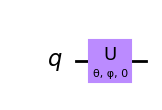

In [4]:
# Parameterの値は未定
ansatz_1q.draw('mpl')

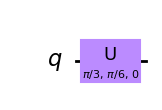

In [5]:
# thetaとphiにπ/3とπ/6を代入
ansatz_1q.bind_parameters({theta: np.pi / 3., phi: np.pi / 6.}).draw('mpl')

変分フォーム回路が作る状態における$X, Y, Z$の期待値を測定するための回路を定義します。

In [6]:
circuits = dict()

# <X>を測るにはHゲートで基底を変換する
circuits['X'] = ansatz_1q.copy()
circuits['X'].h(0)
circuits['X'].measure_all()

# <Y>を測るにはSdg, Hゲートで基底を変換する
circuits['Y'] = ansatz_1q.copy()
circuits['Y'].sdg(0)
circuits['Y'].h(0)
circuits['Y'].measure_all()

# <Z>はそのままの回路で測れる
circuits['Z'] = ansatz_1q.copy()
circuits['Z'].measure_all()

それぞれの回路を通常通りバックエンドの`run()`メソッドで実行し、結果から期待値を計算する関数を定義します。

In [7]:
backend = AerSimulator()

def circuit_expval(circuit, param_vals):
    bound_circuit = circuit.bind_parameters({theta: param_vals[0], phi: param_vals[1]})

    bound_circuit_tr = transpile(bound_circuit, backend=backend)
    # shotsは関数の外で定義する
    job = backend.run(bound_circuit_tr, shots=shots)
    counts = job.result().get_counts()

    return (counts.get('0', 0) - counts.get('1', 0)) / shots

# 例：U(π/3, π/6, 0)|0>
shots = 10000
param_vals = [np.pi / 3., np.pi / 6.]
for pauli in ['X', 'Y', 'Z']:
    print(f'<{pauli}> = {circuit_expval(circuits[pauli], param_vals)}')

<X> = 0.7498
<Y> = 0.431
<Z> = 0.4992


最小化する目的関数を定義します。

In [8]:
def objective_function(param_vals):
    loss = 0.
    for pauli in ['X', 'Y', 'Z']:
        # target_state_1qは関数の外で定義する
        op = SparsePauliOp(pauli)
        target = target_state_1q.expectation_value(op).real
        current = circuit_expval(circuits[pauli], param_vals)
        loss += (target - current) ** 2

    return loss

# 最適化の1ステップごとに呼び出される関数。目的関数の値をリストに記録しておく
def callback_function(param_vals):
    # lossesは関数の外で定義する
    losses.append(objective_function(param_vals))

最適化には使用しませんが、解を得たあとで変分フォームの終状態とターゲット状態とのフィデリティ$|\langle \psi_0 | \psi(\theta, \phi) \rangle|^2$を計算する関数も定義しておきます。厳密に最適化が成功すれば、この関数の返り値は1になります。

In [9]:
def fidelity(ansatz, param_vals, target_state):
    # 量子回路のパラメータのリストはcircuit.parametersで取得できる
    parameters = ansatz.parameters

    param_binding = dict(zip(parameters, param_vals))
    opt_ansatz = ansatz.bind_parameters(param_binding)

    # Statevectorは回路からも生成可能（回路を|0>に対して適用した終状態になる）
    circuit_state = Statevector(opt_ansatz)

    return np.square(np.abs(target_state.inner(circuit_state)))

最後にCOBYLAオプティマイザーのインスタンスを作成し、アルゴリズムを実行します。

In [10]:
# COBYLAの最大ステップ数
maxiter = 500
# COBYLAの収束条件（小さいほどよい近似を目指す）
tol = 0.0001
# バックエンドでのショット数
shots = 1000

# オプティマイザーのインスタンス生成
optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function)

In [11]:
# テキスト作成用のセル

import os
if os.getenv('JUPYTERBOOK_BUILD') == '1':
    del optimizer

In [12]:
# ターゲット状態
target_state_1q = random_statevector(1)

# thetaを[0, π), phiを[0, 2π)からランダムに選ぶ
init = [rng.uniform(0., np.pi), rng.uniform(0., 2. * np.pi)]

# 最適化を実行
losses = list()
min_result = optimizer.minimize(objective_function, x0=init)

NameError: name 'optimizer' is not defined

In [13]:
# テキスト作成用のセル

import pickle
if os.getenv('JUPYTERBOOK_BUILD') == '1':
    with open('data/vqe_results_1q.pkl', 'rb') as source:
        min_result, losses = pickle.load(source)

最適化プロセスにおけるロス（目的関数の返り値）の推移をプロットします。

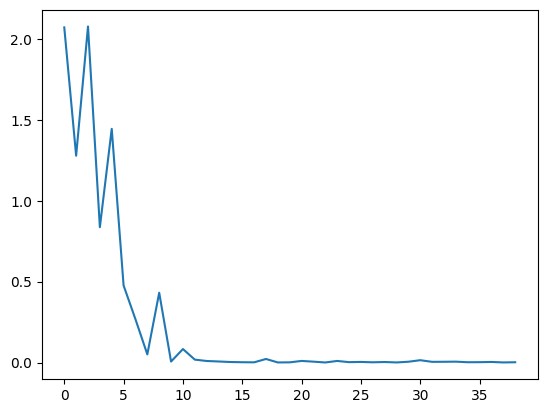

In [14]:
plt.plot(losses);

In [15]:
fidelity(ansatz_1q, min_result.x, target_state_1q)

0.9998472042379072

#### Estimatorの利用

VQEを含む変分量子アルゴリズムでは、上のように変分フォームにパラメータ値を代入し複数の観測量の期待値を計算するという手順の繰り返しが頻出します。そのため、これを自動化し、かつ（今は利用しませんが）様々なエラー補正なども適応してくれるEstimatorというクラスを使用することが推奨されています。特に、ここではBackendEstimatorという、特定のバックエンドを利用して計算をするタイプのEstimatorを利用します。

In [16]:
# BackendEstimatorインスタンスの生成
estimator = BackendEstimator(backend)

# 観測量はSparsePauliOpオブジェクトで表現
observables = [SparsePauliOp('X'), SparsePauliOp('Y'), SparsePauliOp('Z')]

param_vals = [np.pi / 3., np.pi / 6.]

# 変分フォーム、観測量、パラメータ値をrun()に渡す
# 観測量が3つあるので、ansatz_1qとparam_valuesも3つずつ
job = estimator.run([ansatz_1q] * 3, observables, [param_vals] * 3, shots=10000)
result = job.result()
result.values

array([0.7408, 0.4436, 0.5082])

Estimatorを使った目的関数を定義します。

In [17]:
observables_1q = [SparsePauliOp('X'), SparsePauliOp('Y'), SparsePauliOp('Z')]

def objective_function_estimator(param_vals):
    target = np.array(list(target_state_1q.expectation_value(op).real for op in observables_1q))

    job = estimator.run([ansatz_1q] * len(observables_1q), observables_1q, [param_vals] * len(observables_1q), shots=shots)
    current = np.array(job.result().values)

    return np.sum(np.square(target - current))

def callback_function_estimator(param_vals):
    # lossesは関数の外で定義する
    losses.append(objective_function_estimator(param_vals))

上の目的関数を最適化します。

In [18]:
# COBYLAの最大ステップ数
maxiter = 500
# COBYLAの収束条件（小さいほどよい近似を目指す）
tol = 0.0001
# バックエンドでのショット数
shots = 1000

# オプティマイザーのインスタンス生成
optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function_estimator)

In [19]:
# テキスト作成用のセル

if os.getenv('JUPYTERBOOK_BUILD') == '1':
    del optimizer

In [20]:
# ターゲット状態
target_state_1q = random_statevector(1)

# thetaを[0, π), phiを[0, 2π)からランダムに選ぶ
init = [rng.uniform(0., np.pi), rng.uniform(0., 2. * np.pi)]

# 最適化を実行
losses = list()
min_result = optimizer.minimize(objective_function_estimator, x0=init)

NameError: name 'optimizer' is not defined

In [21]:
# テキスト作成用のセル

if os.getenv('JUPYTERBOOK_BUILD') == '1':
    with open('data/vqe_result_1q_estimator.pkl', 'rb') as source:
        min_result = pickle.load(source)

In [22]:
fidelity(ansatz_1q, min_result.x, target_state_1q)

0.9990917238925524

### エンタングルメントの導入

では次に、この問題を2量子ビットに拡張してやってみましょう。2量子ビットの純粋状態は6個の実自由度を持ちますが、ここでは最も一般的に2量子ビット状態を決定する15個の観測量の期待値

$$
\langle O_1 O_2 \rangle \quad (O_1, O_2 = I, X, Y, Z; O_1 O_2 \neq II)
$$

を測定します。ここで$I$は恒等演算子です。

ターゲット状態に関する関数`random_statevector`と`pauli_expval`はそのまま利用できます。まず変分フォームとして2つの量子ビットに$U$ゲートが一つずつかかっているものを考えて、最小化すべき目的関数を定義します。

In [23]:
# パラメータ数4なので、4要素のパラメータベクトルを作る
params = ParameterVector('params', 4)

ansatz_2q = QuantumCircuit(2)
ansatz_2q.u(params[0], params[1], 0., 0)
ansatz_2q.u(params[2], params[3], 0., 1)

In [24]:
paulis_1q = ['I', 'X', 'Y', 'Z']
paulis_2q = list(f'{op1}{op2}' for op1 in paulis_1q for op2 in paulis_1q if (op1, op2) != ('I', 'I'))
observables_2q = list(SparsePauliOp(pauli) for pauli in paulis_2q)

def objective_function_2q(param_vals):
    # target_state_2qは関数の外で定義
    target = np.array(list(target_state_2q.expectation_value(op).real for op in observables_2q))

    job = estimator.run([ansatz_2q] * len(observables_2q), observables_2q, [param_vals] * len(observables_2q), shots=shots)
    current = np.array(job.result().values)

    return np.sum(np.square(target - current))

def callback_function_2q(param_vals):
    # lossesは関数の外で定義する
    losses.append(objective_function_2q(param_vals))

In [25]:
# COBYLAの最大ステップ数
maxiter = 500
# COBYLAの収束条件（小さいほどよい近似を目指す）
tol = 0.0001
# バックエンドでのショット数
shots = 1000

# オプティマイザーのインスタンス生成
optimizer = COBYLA(maxiter=maxiter, tol=tol, callback=callback_function_2q)

# ターゲット状態
target_state_2q = random_statevector(2)

# パラメータの初期値
init = rng.uniform(0., 2. * np.pi, size=4)

In [26]:
# テキスト作成用のセル

if os.getenv('JUPYTERBOOK_BUILD') == '1':
    del optimizer

In [27]:
# 最適化を実行
losses = list()
min_result = optimizer.minimize(objective_function_2q, x0=init)

NameError: name 'optimizer' is not defined

In [28]:
# テキスト作成用のセル

if os.getenv('JUPYTERBOOK_BUILD') == '1':
    with open('data/vqe_result_2q.pkl', 'rb') as source:
        min_result = pickle.load(source)

In [29]:
fidelity(ansatz_2q, min_result.x, target_state_2q)

0.954859915058912

やってみると分かりますが、結果は1量子ビットの場合と比べて良くないですね。どうすれば良くなるでしょうか？（やり方は複数あると思います）

**一つの解決策：変分フォームにエンタングルメントを導入する**

```python
ansatz_2q = QuantumCircuit(2)
ansatz_2q.u(params[0], params[1], 0., 0)
ansatz_2q.u(params[2], params[3], 0., 1)
ansatz_2q.cx(0, 1)
```

どうなるか確かめてください。

2量子ビットの一般の状態では2つのビットがエンタングルしているので、変分フォームに2量子ビットゲートを入れると近似精度が良くなるのはある意味当然です。例えば、ベル状態（[CHSH不等式の破れを確認する](https://utokyo-icepp.github.io/qc-workbook/chsh_inequality.html#id14)を参照）を再現したいときにこの状況をクリアに見ることができます。上で

```python
target_state_2q = random_statevector(2)
```

を

```python
target_state_2q = Statevector(np.array([1., 0., 0., 1.], dtype=complex) / np.sqrt(2.))
```

として実行するとどうなるでしょうか。エンタングルさせる場合とさせない場合で大きな違いが見えるでしょう。

問題を3量子ビットに拡張し、GHZ状態（[単純な量子回路をゼロから書く](https://utokyo-icepp.github.io/qc-workbook/circuit_from_scratch.html#ghz)を参照）

```python
target_state_3q = Statevector(np.array([1.] + [0.] * 6 + [1.], dtype=complex) / np.sqrt(2.))
```

をターゲットにするなどして、遊んでみてください。

(vqe)=
## 変分量子固有値ソルバー法

それでは、ここからVQEの簡単な実装例を見ていくことにします。

(param_shift)=
### パラメータシフト法
VQEを実装する前に、目的関数の勾配を使った最適化の方法（**パラメータシフト法**と呼ばれる）について説明します。あるタイプの変分量子回路では、目的関数の勾配を厳密に計算できることが知られています。その勾配の値を使って、古典計算でパラメータを最適化することができます。

パラメータシフト法を使って勾配を導出するために、まず一般的なパラメータ付きユニタリー演算$U({\boldsymbol \theta})=\prod_{j=1}^LU_j(\theta_j)$を考えます。$U_j(\theta_j)$はパラメータ$\theta_j$を持つユニタリーで、例えば$\theta_j$を回転角とする回転ゲート$U_j(\theta_j)=\exp(-i\theta_jP_j/2)$を考えてみます（$P_j\in\{X,Y,Z\}$はパウリ演算子です）。初期状態$\rho$を$U({\boldsymbol \theta})$で時間発展させた状態に対して、物理量$M$を測定したときの期待値$\langle M({\boldsymbol \theta})\rangle$は

$$
\langle M({\boldsymbol \theta})\rangle=\text{Tr}\left[MU({\boldsymbol \theta})\rho U({\boldsymbol \theta})^\dagger\right] = \text{Tr}\left[MU_{L:1}\rho U_{L:1}^\dagger\right]
$$

になります（ここで$U_{l:m}:=\prod_{j=m}^lU_j(\theta_j)$と略記することにします）。この期待値のパラメータ$\theta_j$に対する勾配は

$$
\frac{\partial}{\partial\theta_j}\langle M({\boldsymbol \theta})\rangle=\text{Tr}\left[M\frac{\partial U_{L:1}}{\partial\theta_j}\rho U_{L:1}^\dagger\right]+\text{Tr}\left[MU_{L:1}\rho\frac{\partial U_{L:1}^\dagger}{\partial\theta_j}\right]
$$

です。$P_j^\dagger=P_j$なので

$$
\begin{aligned}
\frac{\partial U_{L:1}}{\partial\theta_j} &= U_L\ldots U_{j+1}\frac{\partial U_j}{\partial\theta_j}U_{j-1}\ldots U_1=-\frac{i}{2}U_{L:j}P_jU_{j-1:1} \\
\frac{\partial U_{L:1}^\dagger}{\partial\theta_j} &=\frac{i}{2}U_{j-1:1}^\dagger P_jU_{L:j}^\dagger
\end{aligned}
$$

という関係が成り立ちますが、この関係から

$$
\frac{\partial}{\partial\theta_j}\langle M({\boldsymbol \theta})\rangle=-\frac{i}{2}\text{Tr}\left[MU_{L:j}\left[P_j,U_{j-1:1}\rho U_{j-1:1}^\dagger\right]U_{L:j}^\dagger\right]
$$

が得られます。ここで$U_j(\theta_j)$の定義に戻ると、$U_j(\theta_j)=\exp(-i\theta_jP_j/2)=\cos(\theta_j/2)I-i\sin(\theta_j/2)P_j$（$I$は恒等演算子）なので、$U(\pm\pi/2)=(1/\sqrt{2})(I\mp iP_j)$になります。従って、

$$
U_j\left(\frac{\pi}{2}\right)\rho U_j^\dagger\left(\frac{\pi}{2}\right)-U_j\left(-\frac{\pi}{2}\right)\rho U_j^\dagger\left(-\frac{\pi}{2}\right) = \frac12\left(I-iP_j\right)\rho\left(I+iP_j^\dagger\right)-\frac12\left(I+iP_j\right)\rho\left(I-iP_j^\dagger\right) = -i[P_j,\rho]
$$

と書くことができます。この結果を上の$\partial\langle M({\boldsymbol \theta})\rangle/\partial\theta_j$の式に適用すると、

$$
\begin{aligned}
\frac{\partial}{\partial\theta_j}\langle M({\boldsymbol \theta})\rangle &=-\frac{i}{2}\text{Tr}\left[MU_{L:j}[P_j,U_{j-1:1}\rho U_{j-1:1}^\dagger]U_{L:j}^\dagger\right] \\
&= \frac12\text{Tr}\left[MU_{L:j+1}U_j\left(\theta_j+\frac{\pi}{2}\right)U_{j-1:1}\rho U_{j-1:1}^\dagger U_j^\dagger\left(\theta_j+\frac{\pi}{2}\right) U_{L:j+1}^\dagger-MU_{L:j+1}U_j\left(\theta_j-\frac{\pi}{2}\right)U_{j-1:1}\rho U_{j-1:1}^\dagger U_j^\dagger\left(\theta_j-\frac{\pi}{2}\right) U_{L:j+1}^\dagger)\right] \\
&= \frac12\left[\left\langle M\left({\boldsymbol \theta}+\frac{\pi}{2}{\boldsymbol e}_j\right)\right\rangle - \left\langle M\left({\boldsymbol \theta}-\frac{\pi}{2}{\boldsymbol e}_j\right)\right\rangle\right]
\end{aligned}
$$

が得られます。ここで${\boldsymbol e}_j$は$j$番目の要素だけが1でそれ以外は0のベクトルです。

この式から、期待値$\langle M({\boldsymbol \theta})\rangle$のパラメータ$\theta_j$に対する勾配は、$\theta_j$を$\pm\pi/2$だけ増減させて求めた期待値の差として求めることができることが分かりました。これがパラメータシフト法と呼ばれるものです。

(vqe_imp)=
### VQEの実装
では、パラメータシフト法を使って簡単なVQEの例を実装してみます。ある観測量の期待値が最小になるように、VQEを使ってAnsatzを更新する回路パラメータを決定するという問題を考えてみます。

量子回路として、$R_YR_Z$ゲートを繰り返すシンプルなパラメータ回路を使い、観測量として、パウリ演算子のテンソル積$ZXY$を使います。

パラメータシフト法の実装は、QiskitではParamShiftEstimatorGradientというAPIを使うことで一行で済んでしまいます（実際の勾配計算に興味がある人は、期待値から勾配を直接求めるコードを書いて、パラメータ毎に$\pm\pi/2$シフトさせた回路を走らせることで、このAPIと同じ勾配が得られることを確認してみて下さい）。パラメータの最適化は、勾配を使って勾配降下を行うConjugate Descent (CG)とGradient Descentの2つのオプティマイザーを使って行いますが、比較のためにCOBYLAも使うことにします。

最終的に、3通りのVQEを使って求めた最小エネルギーの近似解を、厳密対角化して求めた最小エネルギーの値と比較することにします。

In [30]:
from qiskit.algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import CG, GradientDescent
from qiskit.algorithms.gradients import ParamShiftEstimatorGradient

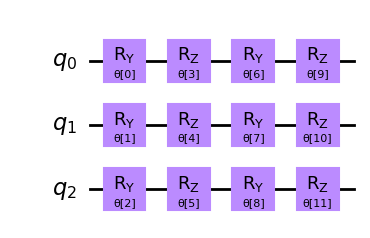

In [31]:
# Ansatzの定義

num_qubits = 3   # 量子ビット数
num_layers = 2  # レイヤー数

ansatz = QuantumCircuit(num_qubits)

# 長さ0のパラメータ配列
theta = ParameterVector('θ')

# 配列に要素を一つ足して、新しく足されたパラメータを返す
def new_theta():
    theta.resize(len(theta) + 1)
    return theta[-1]

for _ in range(num_layers):
    for iq in range(num_qubits):
        ansatz.ry(new_theta(), iq)

    for iq in range(num_qubits):
        ansatz.rz(new_theta(), iq)

    #for iq in range(num_qubits - 1):
    #    ansatz.cx(iq, iq + 1)

ansatz.draw('mpl')

In [32]:
# 最小固有値を求める観測量
obs = SparsePauliOp('ZXY')

# パラメータの初期値
init = rng.uniform(0., 2. * np.pi, size=len(theta))

# Estimatorを使って観測量の勾配を計算するオブジェクト
grad = ParamShiftEstimatorGradient(estimator)

# Conjugate gradientを使ったVQE
optimizer_cg = CG(maxiter=200)
vqe_cg = VQE(estimator, ansatz, optimizer_cg, gradient=grad, initial_point=init)

# Gradient descentを使ったVQE
optimizer_gd = GradientDescent(maxiter=200)
vqe_gd = VQE(estimator, ansatz, optimizer_gd, gradient=grad, initial_point=init)

# COBYLAを使ったVQE
optimizer_cobyla = COBYLA(maxiter=300)
vqe_cobyla = VQE(estimator, ansatz, optimizer_cobyla, initial_point=init)

# 厳密解を計算するソルバー
ee = NumPyMinimumEigensolver()

In [33]:
# テキスト作成用のセル

if os.getenv('JUPYTERBOOK_BUILD') == '1':
    del obs

In [34]:
result_vqe_cg = vqe_cg.compute_minimum_eigenvalue(obs)
result_vqe_gd = vqe_gd.compute_minimum_eigenvalue(obs)
result_vqe_cobyla = vqe_cobyla.compute_minimum_eigenvalue(obs)
result_ee = ee.compute_minimum_eigenvalue(obs)

NameError: name 'obs' is not defined

In [35]:
# テキスト作成用のセルなので無視してよい

with open('data/vqe_results.pkl', 'rb') as source:
    result_ee, result_vqe_cobyla, result_vqe_cg, result_vqe_gd = pickle.load(source)

In [36]:
print('Result:')
print(f'  Exact      = {result_ee.eigenvalue}')
print(f'  VQE(COBYLA) = {result_vqe_cobyla.optimal_value}')
print(f'  VQE(CG)    = {result_vqe_cg.optimal_value}')
print(f'  VQE(GD)    = {result_vqe_gd.optimal_value}')

Result:
  Exact      = -1.0
  VQE(COBYLA) = -0.97265625
  VQE(CG)    = -1.0
  VQE(GD)    = -0.98046875


COBYLAを使ってVQEで求めた答えは、厳密解(=-1.0)に近くなっていると思います。勾配計算を使ったVQEも多くの場合正しい答えに近い答えを返しますが、パラメータの初期値によってかなり悪い結果を返してしまう場合があります。

Ansatzの回路構成を変えたり、観測量を変えてみるなどして色々試してみてください。